In [77]:
#import des libraires nécessaires
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
import glob
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import laBIBILaRORO as lbr
from importlib import reload
#reload(laBIBILaRORO)
from itertools import combinations
#! pip install pingouin
import pingouin as pg
from scipy.stats import f_oneway
from scipy.stats import pearsonr
import re
from scipy.stats import zscore
%matplotlib inline
from IPython.display import display,Image
from scipy.stats import chi2_contingency

from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import pingouin as pg

from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect,MixedEffect
from itertools import chain


In [78]:
#glasser = fetch_parcellation("fsaverage5", "glasser", 360)
#pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
#inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
#pial_combined = fetch_template_surface("fsaverage5", join=True)
#pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
#pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
#inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
#mask = fetch_mask("fsaverage5")

pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [79]:
palette = {
    'bvFTD': '#1f77b4',  # Bleu
    'PPD': '#ff7f0e',  # Orange
    'ADS': '#2ca02c',   # Vert
    'BPD': '#d62728'     # Rouge
}

In [80]:
# Obtenir les couleurs de la colormap 'tab10'
tab10_colors = plt.get_cmap('tab10').colors

# Fonction pour convertir une couleur RGB en code d'échappement ANSI
def rgb_to_ansi(r, g, b):
    return f'\033[38;2;{int(r*255)};{int(g*255)};{int(b*255)}m'

# Convertir les couleurs en codes d'échappement ANSI
ansi_colors = [rgb_to_ansi(*color) for color in tab10_colors]

In [81]:
print(f"La surface utilisée est fsaverage5 avec {pial_combined.GetNumberOfPoints()} points")
print(f"tandis que la fsaverage standard comporte {pial_combined_fslr32k.GetNumberOfPoints()} points")

La surface utilisée est fsaverage5 avec 20484 points
tandis que la fsaverage standard comporte 64984 points


In [82]:
#Chemin 
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","PSY_bvFTD")
DERIVATIVE_DIR1=os.path.join(STUDY_PATH,"data","bids","derivatives")
DERIVATIVE_DIR2=os.path.join("/NAS","deathrow","renaud","MRI_INSCD_maximeBertoux","bids","derivatives")

In [83]:
clinical_data = pd.read_excel(os.path.join(STUDY_PATH,"ETUDES_24092024.xlsx"))#1082024.xlsx"))
print(f"patients : {len(clinical_data)}")

etude1=clinical_data[clinical_data['ETUDE1_IRM']=='oui']
print(f"pts in the study 1 {len(etude1)}")

# Supprimer les lignes où la colonne 'GROUPE' est égale à 'Control'
df_filtered = etude1[etude1['GROUPE'] != 'Control']
print(f"nb pts witout controls : {len(df_filtered)}")


patients : 104
pts in the study 1 83
nb pts witout controls : 83


In [84]:
scanner_data = pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_ProfileJD.xlsx'))
# Effectuer la jointure sur la colonne 'Nom'
merged_data = df_filtered.merge(scanner_data[['Nom', 'MagneticFieldStrength']], on='Nom', how='left')
merged_data.set_index("ID_IRM", inplace=True)
# Afficher le DataFrame résultant avec la colonne 'MagneticFieldStrength'
print(merged_data[['Nom', 'MagneticFieldStrength']])

               Nom  MagneticFieldStrength
ID_IRM                                   
PSY006   BLANCHARD                    1.5
PSY001  BAILLOEUIL                    3.0
PSY011     BUISINE                    NaN
PSY005      BILLON                    3.0
PSY113      BOULET                    1.5
...            ...                    ...
PSY109     ROSTANE                    NaN
PSY087       READY                    NaN
PSY110  SAINT OMER                    NaN
PSY088   SOUILLART                    1.5
PSY089       TOREL                    3.0

[83 rows x 2 columns]


In [85]:
for groupUsed in ['GROUPE', 'SOUS_GROUPE']:
    # Créer une table de contingence pour MagneticFieldStrength et le groupe utilisé
    contingency_table = pd.pivot_table(merged_data, values="DDN", columns='MagneticFieldStrength', index=groupUsed, aggfunc='count', fill_value=0)

    # Afficher la table de contingence
    print(f"Table de contingence pour {groupUsed}:")
    print(contingency_table)

    # Effectuer le test du chi-carré
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Afficher les résultats du test du chi-carré
    print(f"\nRésultats du test du chi-carré pour {groupUsed}:")
    print(f"Chi2: {chi2}")
    print(f"p-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

    # Vérifier s'il y a une différence significative
    if p < 0.05:
        print(f"\nIl y a une différence significative entre les groupes {groupUsed} (p < 0.05).")
    else:
        print(f"\nIl n'y a pas de différence significative entre les groupes {groupUsed} (p >= 0.05).")

Table de contingence pour GROUPE:
MagneticFieldStrength  1.5  3.0
GROUPE                         
PPD                     11   14
bvFTD                   19   23

Résultats du test du chi-carré pour GROUPE:
Chi2: 0.0
p-value: 1.0
Degrees of freedom: 1
Expected frequencies:
[[11.19402985 13.80597015]
 [18.80597015 23.19402985]]

Il n'y a pas de différence significative entre les groupes GROUPE (p >= 0.05).
Table de contingence pour SOUS_GROUPE:
MagneticFieldStrength  1.5  3.0
SOUS_GROUPE                    
ADS                      4    7
BPD                      5    5
bvFTD                   19   23

Résultats du test du chi-carré pour SOUS_GROUPE:
Chi2: 0.42662337662337674
p-value: 0.8079042836464447
Degrees of freedom: 2
Expected frequencies:
[[ 4.88888889  6.11111111]
 [ 4.44444444  5.55555556]
 [18.66666667 23.33333333]]

Il n'y a pas de différence significative entre les groupes SOUS_GROUPE (p >= 0.05).


In [ ]:
#valCT = []
subj2drop=[]
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in chain([0], range(15, 31, 5))}
#valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in [0]}

for smoothing_fwhm in chain([0], range(15, 31, 5)):
    print(f"Smoothing   FWHM: {smoothing_fwhm} mm")
    for elt in merged_data.index:
        sub = f"sub-{str(elt)}"
        if elt.startswith("PSY"):
            if smoothing_fwhm == 0:
                path_file_lh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + "_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii")
                path_file_rh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + "_ses-1_hemi-R_surf-fsaverage5_label-curv.func.gii")
            else:
                path_file_lh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", f"{sub}_ses-1_hemi-L_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")
                path_file_rh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", f"{sub}_ses-1_hemi-R_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")

        print(path_file_lh)
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            #date_bnp = merged_data.loc[elt, 'Date_IRM_Proche_BNP']
            #date_gremots = merged_data.loc[elt, 'Date_IRM_Proche_GREMOTS']
            #if pd.notna(date_bnp) and pd.notna(date_gremots) and date_bnp != date_gremots:
            #    print(f"Index: {elt}")
            #    print(f"Date_IRM_Proche_BNP: {date_bnp}")
            #    print(f"Date_IRM_Proche_GREMOTS: {date_gremots}")
            
            # Uncomment the following lines if you need to load and process the files
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            subj2drop.append(elt)
            print(sub)

merged_data.drop(subj2drop, inplace=True)
print(f"Number of subjects: {len(merged_data)}")
print(f"Number of subjects dropped: {len(subj2drop)}")


Smoothing   FWHM: 0 mm
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY006/ses-1/maps/sub-PSY006_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY011/ses-1/maps/sub-PSY011_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY005/ses-1/maps/sub-PSY005_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY008/ses-1/maps/sub-PSY008_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY010/ses-1/maps/sub-PSY010_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY012/ses-1/maps/sub-PSY012_ses-1_hemi-L_surf-fsaverage5_label-curv.func.gii
/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0

In [93]:
valCT

{'sm_0': [array([ 0.08988786, -0.33140552,  0.04054528, ...,  0.00677294,
         -0.00633272,  0.12517455], dtype=float32),
  array([-0.20947777, -0.42765683, -0.26160833, ..., -0.22055644,
         -0.03126129, -0.01906267], dtype=float32),
  array([-0.07195726,  0.2184657 ,  0.07678016, ..., -0.20325664,
         -0.339921  , -0.30020717], dtype=float32),
  array([-0.24549505, -0.11252851, -0.3112064 , ..., -0.28300282,
         -0.04717658,  0.10711566], dtype=float32),
  array([ 0.0516544 , -0.13004215,  0.1281127 , ...,  0.02508261,
         -0.10451185, -0.07778918], dtype=float32),
  array([-0.12142312, -0.24087124,  0.05930177, ..., -0.1488676 ,
         -0.05224033,  0.02662366], dtype=float32),
  array([-0.04565528, -0.02087819,  0.07555062, ...,  0.13615954,
          0.16358157,  0.18274699], dtype=float32),
  array([-0.25476122, -0.3964762 ,  0.13814177, ..., -0.10855939,
          0.00475381,  0.04225559], dtype=float32),
  array([-0.20254013, -0.20770614, -0.08799753, 

In [75]:
#df_etude1_CT = pd.DataFrame(zscore(np.array(valCT), axis=1), index=df_etude1_scoreAndCov.index)
var4Cov=['AGE','EDUCATION']#,'Gender_1M_0F']
var4Corr_scoresNeurpsy=['FER','mFP','mFP_SocialContext','mFP_Mentalizing','mFP_Controls','Praxies','VOSP','TMT_B_A','Stroop_3-1','Empan_endroit','Empan_envers','CODE_WAIS','Denomination','FCSRT_RL','FCSRT_RT','TOP10'] #'DTLA',
var4Corr_typeErreurs=['FER_EVC','FER_EVN']#,'mFP_IDK','mFP_WrongC','mFP_WrongFP','mFP_Norm','mFP_Altertive','mFP_Irrelevant','mFP_Jugmental','mFP_Consequences','mFP_Malicious','mFP_Undermentalizing','mFP_Intentiol','mFP_WrongEmot','mFP_NoEmot']
var4Corr=var4Corr_scoresNeurpsy+var4Corr_typeErreurs

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm0.jpg


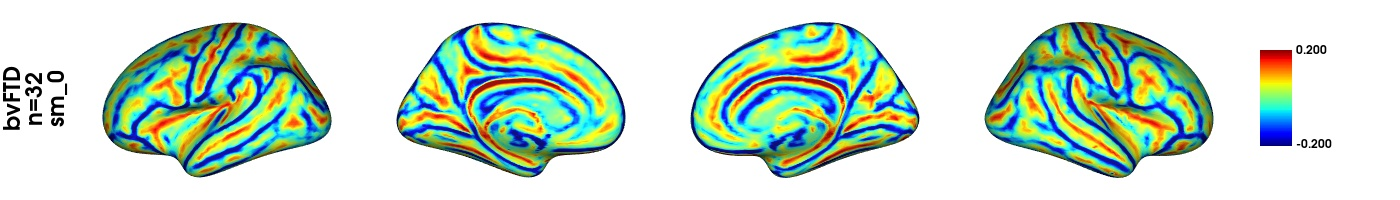

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm0.jpg


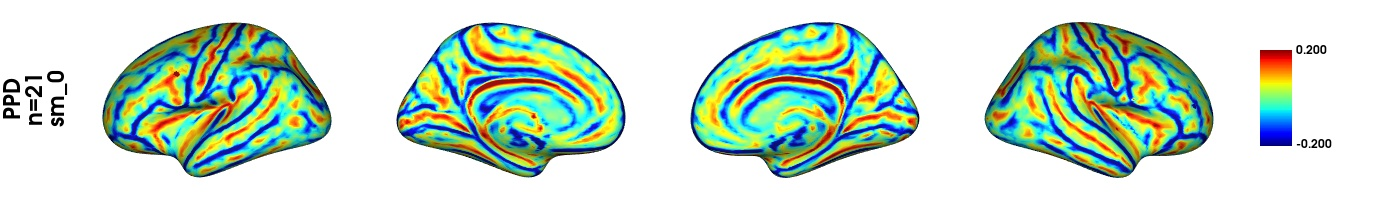

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm0.jpg


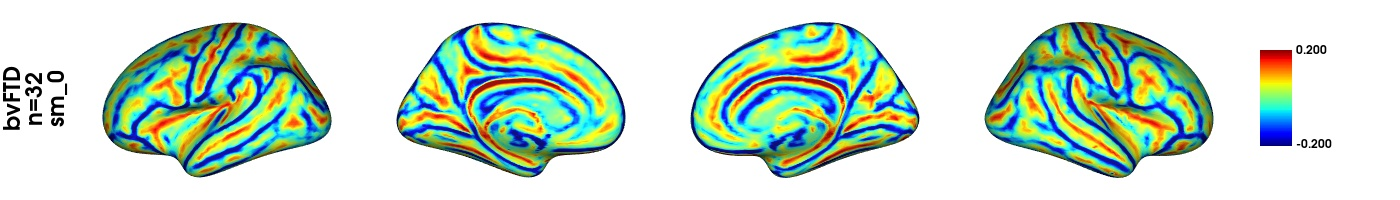

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm0.jpg


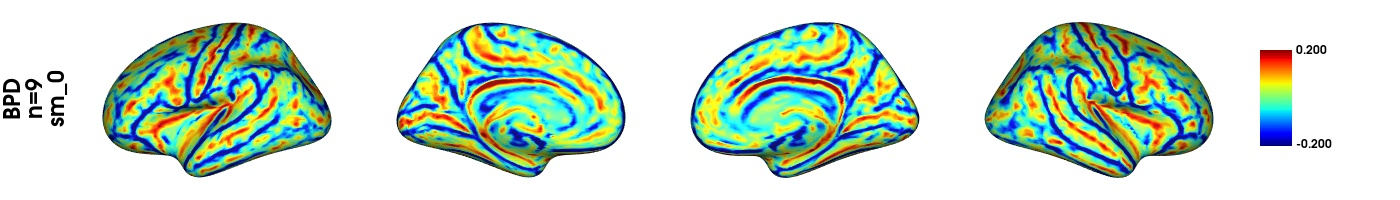

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm0.jpg


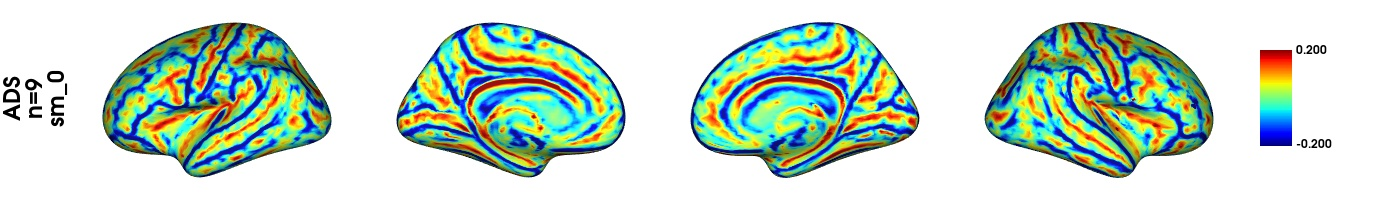

In [76]:
for smoothing_fwhm in [0]:#chain([11], range(15, 31, 5)):
        #Plot the average thickness of the left and right hemispheres on the fsaverage5 surface    
        for groupUsed in ['GROUPE','SOUS_GROUPE'] :
                for gp in merged_data[groupUsed].dropna().unique():
                        figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_{groupUsed}_vs_{gp}_sm{smoothing_fwhm}.jpg")
                        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)       
                #        labText=f"{np.sum(ssdf_covar[groupUsed] == pair[0])} {pair[0]}\n{np.sum(ssdf_covar[groupUsed] == pair[1])} {pair[1]}"
                        df_tmp_gp=df_etude1_CT.loc[merged_data[groupUsed] == gp]
                        plot_hemispheres(inflated_left,inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True, color_range=(-0.2,0.2),
                                label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                                nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                        #cmap="autumn",label_text=[labText],
                        print(f"figure_title : {figure_title}")                        
                        display(Image(filename=figure_title))

In [72]:
reload(lbr)
pd.option_context('mode.use_inf_as_na', True)
for smoothing_fwhm in [0]:# chain([11], range(15, 31, 5)):
    for groupUsed in ['GROUPE','SOUS_GROUPE'] :
        print(f"\033[1;31m******************************\n{groupUsed}, smooting à {smoothing_fwhm}\n***************************** \033[0m")  
        # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
        pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
        for pair in pairs: # Itérez sur tous les couples
            df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)
            ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]

            #Régression de l'age et du niveau d'education
            #lbr.regress_covar_func(df_etude1_CT.columns,var4Cov,ssdf_CT,merged_data.loc[merged_data[groupUsed].isin([pair[0],pair[1]])][var4Cov],True)

            ssdf_covar = merged_data.loc[ssdf_CT.index]

            # Construire le chemin du répertoire
            directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

            # Créer le répertoire s'il n'existe pas
            os.makedirs(directory_path, exist_ok=True)
            lbr.grp_comp_surface_func(groupUsed,var4Cov,ssdf_covar,ssdf_CT,directory_path,MyPalette=palette,threshold_p=0.1,threshold_size=10)

La bibil à RORO loaded
******************************
GROUPE, smooting à 0
***************************** 
Group comparison between bvFTD and PPD
fitting the model
******************************
SOUS_GROUPE, smooting à 0
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
Group comparison between BPD and ADS
fitting the model


In [73]:
import warnings
warnings.filterwarnings('ignore')
reload(lbr)
plt.tight_layout()
for smoothing_fwhm in [0]:#chain([11], range(15, 31, 5)):
    print(f"\033[1;31m******************************\nSmooting à {smoothing_fwhm}\n***************************** \033[0m")  
    for varCorr in var4Corr:
        print(varCorr)
        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)
        # Construire le chemin du répertoire
        directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

        # Créer le répertoire s'il n'existe pas
        os.makedirs(directory_path, exist_ok=True)
        lbr.corr_surface_var_func([varCorr],var4Cov,merged_data,df_etude1_CT,directory_path,MyPalette=palette)

La bibil à RORO loaded
******************************
Smooting à 0
***************************** 
FER
mFP
mFP_SocialContext
mFP_Mentalizing
mFP_Controls
Praxies
VOSP
TMT_B_A
Stroop_3-1
Empan_endroit
Empan_envers
CODE_WAIS
Denomination
FCSRT_RL
FCSRT_RT
TOP10
FER_EVC
FER_EVN


<Figure size 640x480 with 0 Axes>

In [16]:
!jupyter nbconvert --no-input --to pdf DFTvc_MB_etude1.ipynb 

[NbConvertApp] Converting notebook DFTvc_MB_etude1.ipynb to pdf
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/javascript', 'application/vnd.holoviews_load.v0+json']) is not able to be represented.
  warn(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.holoviews_exec.v0+json', 'text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in DFTvc_MB_etude1_files/
[NbConvertApp] Making directory ./DFTvc_MB_etude1_files
[NbConvertApp] Making directory ./DFTvc_MB_etude1_files
[NbConvertApp] Making directory ./DFTvc_MB_

# Autre design matriX

In [ ]:
reload(lbr)

for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"\033[1;31m******************************\n{groupUsed}\n***************************** \033[0m")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        
        #ssdf_covar = df_etude1_scoreAndCov.loc[df_etude1_scoreAndCov[groupUsed].isin([pair[0],pair[1]])]
        #ssdf_CT = df_etude1_CT.loc[df_etude1_scoreAndCov[groupUsed].isin([pair[0],pair[1]])]
        #print(ssdf.shape,ssdf[col_list].dropna(axis=0).shape,ssdf[col_list].dropna(axis=1).shape)
    
        ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]
        ssdf_covar = merged_data.loc[ssdf_CT.index]
   
        contrast_group = (ssdf_covar[groupUsed] == pair[0]).astype(int) - (ssdf_covar[groupUsed] == pair[1]).astype(int)
        term_group = FixedEffect(ssdf_covar[groupUsed])
        
        #model_group = term_group
        #model_group_age_educ=model_group
        
        #for varc in var4Cov:
        #    model_group_age_educ = model_group_age_educ + FixedEffect(ssdf_covar[varc])

        term_age = FixedEffect(ssdf_covar[var4Cov[0]])
        term_educ = FixedEffect(ssdf_covar[var4Cov[1]])
        #term_subject = MixedEffect(ssdf_covar["IDENTIFIANT"])
    
        #Créer le modèle avec covariables
        model_group_age_educ = term_group + term_age + term_educ + term_age * term_educ #+ term_subject
    
        slm_group = SLM(
            model_group_age_educ,
            contrast_group,
            surf=pial_combined,
            mask=mask,
            correction=["fdr", "rft"],
            two_tailed=True,
            cluster_threshold=0.01,
        )
        
        slm_group.fit(ssdf_CT.values)
        
        cp = [np.copy(slm_group.P["pval"]["C"])]
        [np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
        
        threshold_p=0.01
        threshold_size=50
        for contrast in [0,1]:           
            filtered_df = slm_group.P['clus'][contrast][(slm_group.P['clus'][contrast]['nverts'] > threshold_size) & (slm_group.P['clus'][contrast]['P'] < threshold_p)]
            if len(filtered_df)>0 :
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_{pair[0]}_vs_{pair[1]}_contrast{contrast}.jpg")
                labText=f"{np.sum(ssdf_covar[groupUsed] == pair[0])} {pair[0]}\n{np.sum(ssdf_covar[groupUsed] == pair[1])} {pair[1]}"
                max_cluster_nb=np.max(filtered_df["clusid"].values)
                test = np.copy(slm_group.P["clusid"][contrast].reshape(-1))
                test = np.where(test > max_cluster_nb, 0, test)
                plot_hemispheres(inflated_left, inflated_right,test,label_text=[labText],color_range=(0,9),color_bar=True,
                    cmap="tab10", embed_nb=True, size=(1400, 200),zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1),
                    cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
                display(Image(filename=figure_title))
                print(f"{lbr.BLUE}***** \n clusters infos : \n***** \n {lbr.RESET} {filtered_df}")
                df_tmp=slm_group.P['peak'][contrast]
                print(f"{lbr.BLUE}***** \n peaks infos : \n***** \n {lbr.RESET} {df_tmp[(df_tmp['clusid'] <= max_cluster_nb)]}")
                for clu in filtered_df["clusid"].values :
                    df_copy=ssdf_covar.loc[:,[groupUsed]+var4Cov]
                    inds=np.where(slm_group.P['clusid'][contrast]==clu)[1]
                    name=f"cluster_{str(clu)}"
                    print(f'{lbr.ansi_colors[clu]} {lbr.BOLD} {name} {lbr.RESET}')
                    df_copy[name] = np.mean(ssdf_CT.values[:,inds],1)
                    plt.figure()
                    ax = plt.gca()
                    lbr.regress_covar_func([name],var4Cov,df_copy,df_copy,False)
                    # Faire une copie du dictionnaire palette
                    palette_copy = palette.copy()

                    # Obtenir les groupes uniques présents dans df_copy
                    groups_present = df_copy[groupUsed].unique()

                    # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                    palette_copy = {group: color for group, color in palette_copy.items() if group in groups_present}

                    sns.stripplot(df_copy,y=name,x=groupUsed,size=3,color="black", order=palette_copy.keys())
                    sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())
                    figure_title=os.path.join(STUDY_PATH,f"groups_compare_{name}_contrast{contrast}.png")
                    plt.savefig(figure_title)
                    plt.close()
                    display(Image(filename=figure_title))

                    # Effectuer un test t avec Pingouin
                    ttest_results = pg.ttest(df_copy[df_copy[groupUsed] == pair[0]][name],df_copy[df_copy[groupUsed] == pair[1]][name])
                    tvalue=ttest_results["T"].values[0]
                    pvalue=ttest_results["p-val"].values[0]
                    print(f"T-Test (oneside) : {tvalue:.3f} and p_value = {pvalue:.3f}")